# 사내 직원의 퇴사여부 예측하기

## 프로젝트 목차
1. 프로젝트 개요
2. 데이터 분석(EDA)
    - Feature Overview 분석
    - 각 Feature Detail 분석
    - EDA 결과 정리
3. 데이터 전처리
    - 모델에 들어갈 데이터 셋 만들기
4. 모델 만들기
    - 모델 설명
5. 모델 성능 평가하기
6. 결론 및 보완점

## 1. 프로젝트 개요
kaggle "Employee Future Prediction"의 데이터 셋을 활용하였다. 해당 데이터 셋은 인도의 어느 회사 HR 부서에서 12 ~ 18년 직원의 데이터를 바탕으로 해당 직원이 2년 후(2020년) 퇴사를 할 것인지를 예측하는 상황으로 가정이 되어있다.
데이터를 분석하여 인사이트를 작업과 직원들의 퇴사 여부를 예측하는 해보는 작업이 프로젝트의 목표이다. 

### 요약
- 데이터를 facet, matplotlib, padnas로 분석한 후 전처리
- tf.dataset으로 만들고 wide_and_deep 딥러닝 모델에 넣어 학습을 진행(keras API 활용)
- sklearn을 활용하여 학습된 모델을 평가한다.

data url : https://www.kaggle.com/tejashvi14/employee-future-prediction

In [1]:
# numpy, pandas
import numpy as np
import pandas as pd
import shutil
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib import cm

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import (Dense, DenseFeatures, Input, Dropout, concatenate)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow import feature_column

# facets
from IPython.core.display import display, HTML
import base64
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [2]:
# data load. 
raw_dataset = pd.read_csv('/Users/jk/git/Study/Data/Kaggle_dataset/Employee Future Prediction/Employee.csv', 
    na_values=['?', '??', 'N/A', 'NA', 'nan', 'NaN', '-nan', '-NaN', 'null'])

raw_dataset.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


## 2. 데이터 분석 (EDA) 
데이터 분석은 다음과 같은 순서로 진행된다. 
1. facets_overview를 통해 데이터 overview 살펴보기
2. facets_detail을 통해 Feature에 대해 자세히 살펴보기
3. feature들 사이의 관계 살펴보기

데이터 분석(EDA)의 목적
- 데이터 전처리 설계를 위해
- 데이터로부터 인사이트를 얻기 위해
- 데이터에 나타나는 여러 유형의 편향 이해도를 높임
- 잠재적인 데이터 편향 요인 파악

## 2. 데이터 분석 (EDA) - Feature overview 분석
구글에서 개발한 오픈소스 facets_overview을 통해 손쉽게 모든 feature의 overview를 볼 수 있다. 
overview에서 주요하게 살펴볼 내용은 
1. 어떤 타입의 특성들이 얼마나 있는지(int, float, string 등)
2. 누락된 값들이 각 특성마다 얼마나 있는지
3. 값들의 분포가 어떻게 되어있는지(불균형한지, 균형적인지)


*facet을 사용하기 위해서 facets-overview, protobuf를 pip으로 설치해 주어야 한다. 

In [3]:
# facets_overview를 Ipython에 동작하기 위한 코드이다. 

fsg = FeatureStatisticsGenerator()
dataframes = [{'table': raw_dataset, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode('utf-8')

HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

![facet_overview](./image/facet_overview.png)

##  Feature overview 분석
- 데이터는 총 4653개이며 9개(int 5, string 4)의 Feature
- NA 값을 갖는 Feature는 없음
- Education, EverBenched, PaymentTier 같은 컬럼에서 데이터가 특정 값에 몰려있다. 추가적으로 어떤 의미를 가지는지 확인할 필요가 있다.

## 2. 데이터 분석 (EDA) - 각 Feature Detail 분석
facets_detail을 통해 Feature에 대해 자세히 살펴볼 것이다. Feature 끼리의 관계는 물론 해당 Feature가 퇴사율에 어떤 영향을 미치는지에 대해 중점적으로 살펴볼 예정이다. 그리고 주목할 만한 특징을 발견하면 정확한 수치 값을 구해볼 것이다. 

In [4]:
# facets_detail을 Ipython에 동작하기 위한 코드이다. 
# facets_overview와 다른점은 데이터셋을 json으로 매핑해주어야 한다.
# 아래의 그림에서 X축과 Y축, Color 등에 들어갈 Feature를 바꿔주면서 값들의 관계를 파악해볼 수 있다. 

jsonstr = raw_dataset.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

![facet_detail](./image/facet_detail.png)

In [5]:
NUMERIC_FEATURES = ["JoiningYear", "PaymentTier", "Age", "ExperienceInCurrentDomain"]
CATEGORY_FEATURES = ["Gender", "Education", "City", "EverBenched"]
LABELS = ["LeaveOrNot"]

# 분석용 데이터셋
for_EDA = raw_dataset.copy()
for_EDA["LeaveOrNot"] = for_EDA['LeaveOrNot'].map({1: "Leave", 0: "NotLeave"})

## "JoiningYear" Feature
JoiningYear는 회사에 입사한 연도를 의미하는 Feature로, 12~18년까지의 범위 데이터를 가지고 있다. 연도별 입사한 직원 비율은 각 11%, 14%, 15%, 17%, 11%, 24%, 8%이다. 퇴사율은 12년(21%), 13년(33%), 14년(24%), 15년(40%), 16년(22%), 17년(26%), 18년(98%)이다.

- 18년에 입사한 직원의 퇴사율은 98%에 달한다. 
- 12년에 입사한 직원들 중 30대 이상 직원들의 퇴사율은 17%로 12년에 입사한 직원 퇴사율(21%)에 비해 낮다. 특히 40대의 퇴사율은 4%로 매우 낮다.
- 16년에 입사한 직원들 중 22-24세 직원들의 퇴사율은 7%로 16년에 입사한 직원 퇴사율(22%)에 비해 낮다.
- 15년에 입사한 직원 중 Bangalore, New Delhi에서 근무하는 직원의 퇴사율은 21%, 23%이며 Pune 지역에 근무하는 직원의 퇴사율(66%)보다 낮다.
- 12, 13, 17년에 입사한 직원 중 석사 학력이 있는 직원의 퇴사율은 55%, 68%, 40%로 각 연도별 퇴사율(21%, 33%, 26%)에 비해 높다.
- 12년, 14년, 16년에 입사한 직원 중 장기 프로젝트를 하지 않은 직원의 퇴사율은 12%, 10%, 8%로 연도별 퇴사율(21%, 24%, 22%)에 비해 낮다.
- 15년에 입사한 직원 중 남성 직원의 퇴사율이 16%로 15년 입사한 직원 퇴사율(40%) 보다 낮다. 
- 17년에 입사한 직원 중 1티어의 연봉을 받는 직원의 퇴사율은 16%로 17년 입사한 직원 퇴사율(26%) 보다 낮다.
- 17년을 제외하고 pay 2티어를 받는 직원의 퇴사율은 68%로 높다(특히 16, 18년 입사한 직원들의 퇴사율은 100%이다)

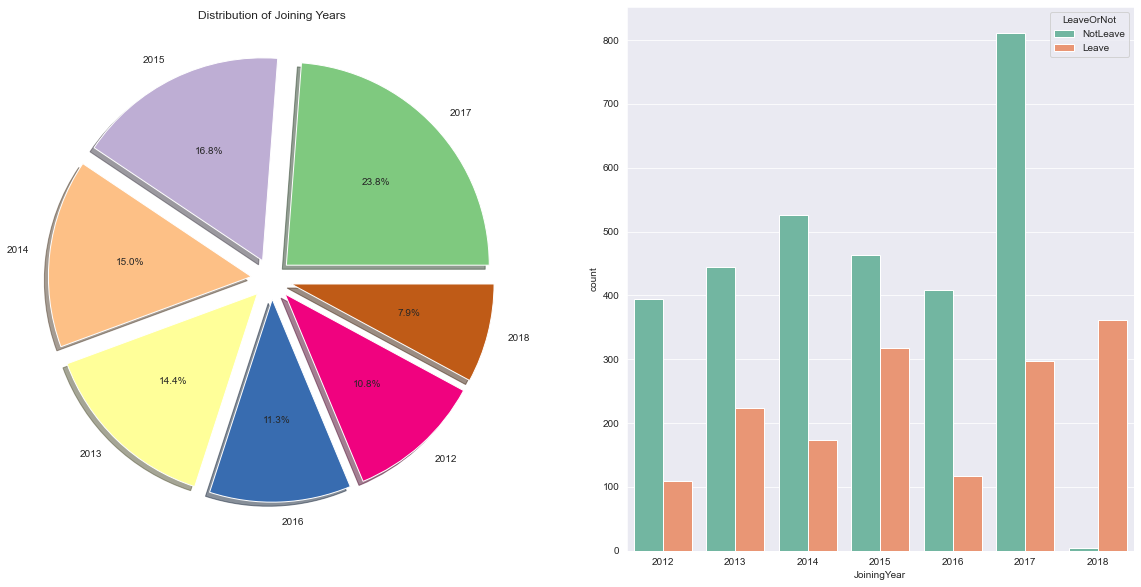

In [6]:
# 연도별 직원 비율 및 연도별 직원 퇴사 현황

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
labels = for_EDA['JoiningYear'].value_counts().keys()
colors =cm.Accent(np.arange(7)/7)
plt.pie(x = for_EDA['JoiningYear'].value_counts(), 
       labels = labels,
       explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1),
       shadow = True, 
       colors = colors,
       autopct='%1.1f%%')
plt.title('Distribution of Joining Years')

plt.subplot(1,2,2)
sns.countplot(x = for_EDA['JoiningYear'], hue = for_EDA['LeaveOrNot'] , palette='Set2')
plt.show()

In [7]:
# 연도별 퇴사 비율
for_EDA_j = for_EDA.groupby("JoiningYear")
print(f"연도별 퇴사 비율 : {for_EDA_j['LeaveOrNot'].value_counts(normalize=True)}\n")

# 12년 입사 & 30대 이상
for_EDA_j12_3040 = for_EDA[(for_EDA.JoiningYear == 2012) & (for_EDA.Age >= 30)]
print(f"12년 입사 & 30대 이상 : {for_EDA_j12_3040['LeaveOrNot'].value_counts(normalize=True)}\n")

# 12년 입사 & 40대 이상
for_EDA_j12_40 = for_EDA[(for_EDA.JoiningYear == 2012) & (for_EDA.Age >= 40)]
print(f"12년 입사 & 40대 이상 : {for_EDA_j12_40['LeaveOrNot'].value_counts(normalize=True)}\n")

# 16년 입사 & 22-24세
for_EDA_j16_2224 = for_EDA[(for_EDA.JoiningYear == 2016) & (for_EDA.Age.isin([22, 23]))]
print(f"16년 입사 & 22-24세 : {for_EDA_j16_2224['LeaveOrNot'].value_counts(normalize=True)}\n")

# 15년 입사 & 지역별
for_EDA_j15_ct = for_EDA[for_EDA.JoiningYear == 2015].groupby("City")
print(f"15년 입사 & 지역별 : {for_EDA_j15_ct['LeaveOrNot'].value_counts(normalize=True)}\n")

# 12, 13, 17년 입사 & 석사 학력
for_EDA_j121317_ms = for_EDA[(for_EDA.JoiningYear.isin([2012, 2013, 2017])) & (for_EDA.Education == "Masters")].groupby("JoiningYear")
print(f"12, 13, 17년 입사 & 석사 학력 : {for_EDA_j121317_ms['LeaveOrNot'].value_counts(normalize=True)}\n")

# 12, 14, 16년 입사 & 1달이상 프로젝트 참여 x
for_EDA_j121416_eb = for_EDA[(for_EDA.JoiningYear.isin([2012, 2014, 2016])) & (for_EDA.EverBenched == "Yes")].groupby("JoiningYear")
print(f"12, 14, 16년 입사 & 1달이상 프로젝트 참여 x : {for_EDA_j121416_eb['LeaveOrNot'].value_counts(normalize=True)}\n")

# 15년 입사 & 남성
for_EDA_j15_male = for_EDA[(for_EDA.JoiningYear == 2015) & (for_EDA.Gender == 'Male')]
print(f"15년 입사 & 남성 : {for_EDA_j15_male['LeaveOrNot'].value_counts(normalize=True)}\n")

# 17년 입사 & pay 1
for_EDA_j17_pay1 = for_EDA[(for_EDA.JoiningYear == 2017) & (for_EDA.PaymentTier == 1)]
print(f"17년 입사 & pay 1 : {for_EDA_j17_pay1['LeaveOrNot'].value_counts(normalize=True)}\n")

# 17년 제외 입사 & pay 2
for_EDA_pay2 = for_EDA[for_EDA.PaymentTier == 2]
for_EDA_nj17_pay2 = for_EDA[(for_EDA.JoiningYear != 2017) & (for_EDA.PaymentTier == 2)]
print(f"17년 제외 입사 & pay 2 : {for_EDA_nj17_pay2['LeaveOrNot'].value_counts() / for_EDA_pay2['LeaveOrNot'].value_counts()}\n")



연도별 퇴사 비율 : JoiningYear  LeaveOrNot
2012         NotLeave      0.783730
             Leave         0.216270
2013         NotLeave      0.665172
             Leave         0.334828
2014         NotLeave      0.752504
             Leave         0.247496
2015         NotLeave      0.592830
             Leave         0.407170
2016         NotLeave      0.777143
             Leave         0.222857
2017         NotLeave      0.731949
             Leave         0.268051
2018         Leave         0.986376
             NotLeave      0.013624
Name: LeaveOrNot, dtype: float64

12년 입사 & 30대 이상 : NotLeave    0.821622
Leave       0.178378
Name: LeaveOrNot, dtype: float64

12년 입사 & 40대 이상 : NotLeave    0.956522
Leave       0.043478
Name: LeaveOrNot, dtype: float64

16년 입사 & 22-24세 : NotLeave    0.928571
Leave       0.071429
Name: LeaveOrNot, dtype: float64

15년 입사 & 지역별 : City       LeaveOrNot
Bangalore  NotLeave      0.789809
           Leave         0.210191
New Delhi  NotLeave      0.768657
     

## "PaymentTier" Feature
PaymentTier는 직원들이 받는 연봉의 정도를 의미하는 것으로 3: Lowest, 2: Mid level, 1 : Highest이다. 각 비율은 75%, 20%, 5%이고, 퇴사율은 각 37%, 60%, 27%이다.

특이점
- pay를 1티어로 받는 직원 중 Bangalore에서 근무하는 직원의 퇴사율은 18%로 pay를 1티어로 받는 직원의 퇴사율(27%) 보다 낮다.
- pay를 2티어로 받는 직원 중 박사 학력이 있는 직원의 퇴사율은 35%로, 2티어를 받는 직원 퇴사율(60%)보다 낮다.
- pay를 2티어로 받는 직원 중 1개월 이상 프로젝트를 하지 않은 직원의 퇴사율은 80%로 2티어를 받는 직원 퇴사율(60%)보다 높다.
- pay를 1티어로 받는 직원 중 1개월 이상 프로젝트를 하지 않은 직원의 퇴사율은 50%로 1티어를 받는 직원 퇴사율(27%)보다 높다.
- pay를 1티어로 받는 직원 중 남성 직원의 퇴사율은 18%로 pay를 1티어로 받는 직원의 퇴사율(27%)보다 낮다.
- pay를 2티어로 받는 직원 중 남성 직원의 퇴사율은 40%로 pay를 2티어로 받는 직원의 퇴사율(60%)보다 낮다. 
- pay를 2,3 티어로 받는 직원 중 18년도에 입사한 직원의 퇴사율은 100%이다. 1티어로 받는 직원의 퇴사율은 37%이다.

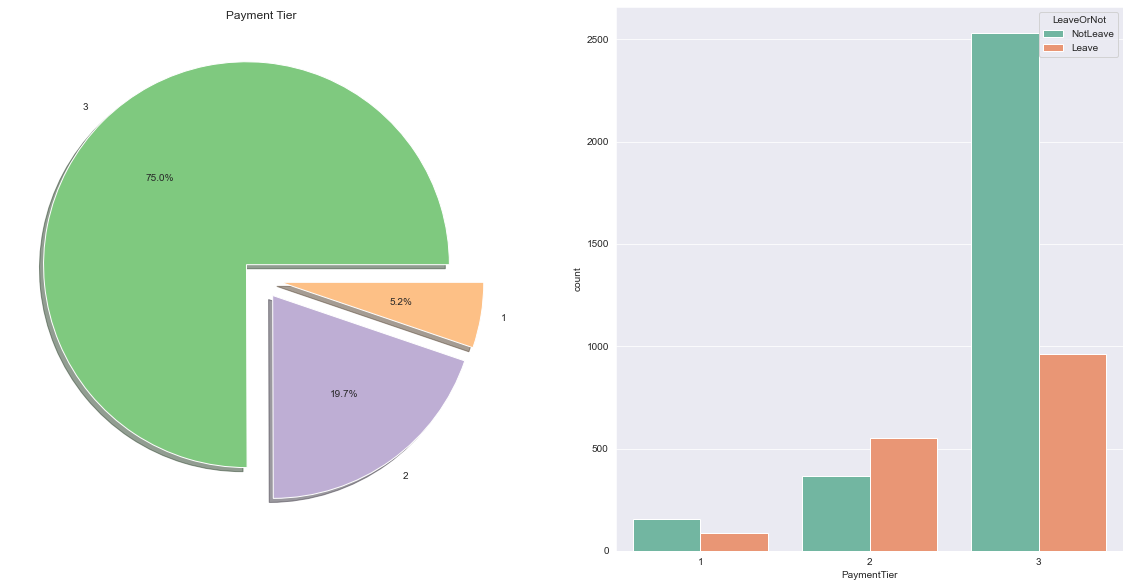

In [8]:
# pay 등급 비율 및 pay에 따른 직원 퇴사 현황
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
labels = for_EDA['PaymentTier'].value_counts().keys()
plt.pie(x = for_EDA['PaymentTier'].value_counts(), 
       labels = labels,
       explode = (0.1,0.1,0.1),
       shadow = True, 
       colors = colors,
       autopct='%1.1f%%')
plt.title('Payment Tier')

plt.subplot(1,2,2)
sns.countplot(x = for_EDA['PaymentTier'], hue = for_EDA['LeaveOrNot'] , palette='Set2')
plt.show()

In [9]:
# PaymentTier에 따른 퇴사 비율 확인
print(f"PaymentTier에 따른 퇴사 비율 확인 : {for_EDA.groupby('PaymentTier')['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 1 & Bangalore
for_EDA_pay1_ba = for_EDA[(for_EDA.PaymentTier == 1) & (for_EDA.City == "Bangalore")]
print(f"pay 1 & Bangalore : {for_EDA_pay1_ba['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 2 & 박사 학력
for_EDA_pay2_ph = for_EDA[(for_EDA.PaymentTier == 2) & (for_EDA.Education == "PHD")]
print(f"pay 2 & 박사 학력 : {for_EDA_pay2_ph['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 2 & 1개월 이상 프로젝트를 하지 x
for_EDA_pay2_eb = for_EDA[(for_EDA.PaymentTier == 2) & (for_EDA.EverBenched == "Yes")]
print(f"pay 2 & 1개월 이상 프로젝트를 하지 x : {for_EDA_pay2_eb['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 1 & 1개월 이상 프로젝트를 하지 x
for_EDA_pay1_eb = for_EDA[(for_EDA.PaymentTier == 1) & (for_EDA.EverBenched == "Yes")]
print(f"pay 1 & 1개월 이상 프로젝트를 하지 x : {for_EDA_pay1_eb['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 1 & 남성
for_EDA_pay1_male = for_EDA[(for_EDA.PaymentTier == 1) & (for_EDA.Gender == "Male")]
print(f"pay 1 & 남성 : {for_EDA_pay1_male['LeaveOrNot'].value_counts(normalize=True)}\n")

# pay 2 & 남성
for_EDA_pay2_male = for_EDA[(for_EDA.PaymentTier == 2) & (for_EDA.Gender == "Male")]
print(f"pay 2 & 남성 : {for_EDA_pay2_male['LeaveOrNot'].value_counts(normalize=True)}\n")


PaymentTier에 따른 퇴사 비율 확인 : PaymentTier  LeaveOrNot
1            NotLeave      0.633745
             Leave         0.366255
2            Leave         0.599129
             NotLeave      0.400871
3            NotLeave      0.724800
             Leave         0.275200
Name: LeaveOrNot, dtype: float64

pay 1 & Bangalore : NotLeave    0.821429
Leave       0.178571
Name: LeaveOrNot, dtype: float64

pay 2 & 박사 학력 : NotLeave    0.65
Leave       0.35
Name: LeaveOrNot, dtype: float64

pay 2 & 1개월 이상 프로젝트를 하지 x : Leave       0.806452
NotLeave    0.193548
Name: LeaveOrNot, dtype: float64

pay 1 & 1개월 이상 프로젝트를 하지 x : Leave       0.5
NotLeave    0.5
Name: LeaveOrNot, dtype: float64

pay 1 & 남성 : NotLeave    0.821429
Leave       0.178571
Name: LeaveOrNot, dtype: float64

pay 2 & 남성 : NotLeave    0.600639
Leave       0.399361
Name: LeaveOrNot, dtype: float64



## "Age" Feature
직원들의 나이를 나타내는 특성이다. 22 ~ 41세의 나이대이며 20대가 가장 많다. 2살 단위로 자른 비율은 22-23(2%), 24-25(17%), 26-27(27%), 28-29(18%), 30-31(7%), 32-33(6%), 34-35(6%), 36-37(6%), 38-39(6%), 40-41(5%)이다. 퇴사율은 22-23(36%), 24-25(40%), 26-27(35%), 28-29(30%), 30-31(33%), 32-33(36%), 34-35(33%), 36-37(31%), 38-39(30%), 40-41(30%)이다.

특이점
- 22-23, 24-25, 26-27 세의 직원 중 석사 학위를 가진 직원의 퇴사율은 77%, 61%, 63%로 해당 연령별 직원 퇴사율(36%, 40%, 35%)보다 높다.
- 22-23세의 직원은 경력이 0,1, 24-25세 직원의 경력은 2,3, 26-27 직원의 경력은 4,5로 형성되어 있다. 나이가 어릴수록 경력 쌓기가 쉽지 않기 때문으로 예상된다.
- 22-23세, 24-25세의 직원 중 pay 2티어를 받는 직원의 퇴사율은 79%, 74%로 해당 나이대 직원 퇴사율(36%, 40%) 보다 높다.

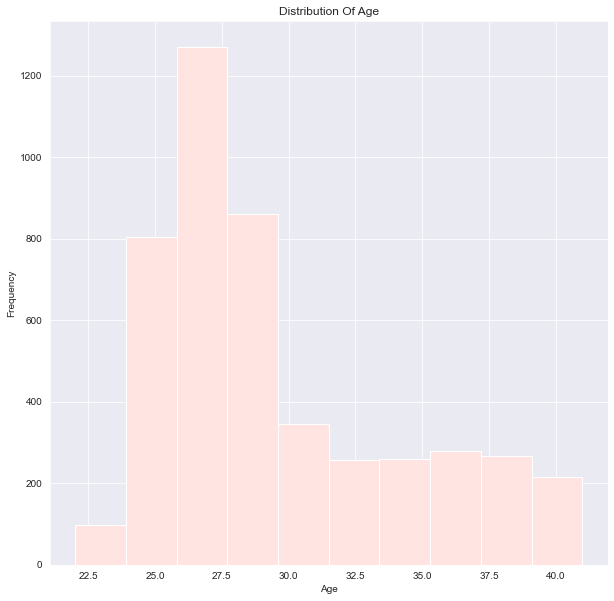

In [10]:
plt.figure(figsize = (10, 10))
for_EDA['Age'].plot(kind = 'hist', color = 'mistyrose', edgecolor = 'white')
plt.xlabel("Age")
plt.title('Distribution Of Age')

plt.show()

In [11]:
# 2살 단위로 자르기
for_EDA_age = for_EDA.copy()
age_string = {}
for num in range(22, 42):
    if num % 2 == 0:
        value = str(num) + "-" +str(num+1)
    age_string[num] = value

for_EDA_age['Age_string'] = for_EDA['Age'].map(age_string)


# 연령별 비율
print(f"연령별 비율 : {for_EDA_age['Age_string'].value_counts(normalize=True)}")

# 연령별 퇴사율
print(f"연령별 퇴사율 : {for_EDA_age.groupby('Age_string')['LeaveOrNot'].value_counts(normalize=True)}")

# 22-23, 24-25, 26-27세 & 석사 학력
for_EDA_age2227_ms = for_EDA_age[(for_EDA_age.Age_string.isin(["22-23", "24-25", "26-27"])) & (for_EDA_age.Education == "Masters")].groupby('Age_string')
print(f"22-23, 24-25, 26-27세 & 석사 학력 : {for_EDA_age2227_ms['LeaveOrNot'].value_counts(normalize=True)}\n")

# 22-23, 24-25세 & pay 2
for_EDA_age2225_pay2 = for_EDA_age[(for_EDA_age.Age_string.isin(["22-23", "24-25"])) & (for_EDA_age.PaymentTier == 2)].groupby('Age_string')
print(f"22-23, 24-25세 & pay 2 : {for_EDA_age2225_pay2['LeaveOrNot'].value_counts(normalize=True)}\n")



연령별 비율 : 26-27    0.272942
28-29    0.184827
24-25    0.172577
30-31    0.074146
36-37    0.060176
38-39    0.057382
34-35    0.055663
32-33    0.055018
40-41    0.046422
22-23    0.020847
Name: Age_string, dtype: float64
연령별 퇴사율 : Age_string  LeaveOrNot
22-23       NotLeave      0.639175
            Leave         0.360825
24-25       NotLeave      0.590286
            Leave         0.409714
26-27       NotLeave      0.646457
            Leave         0.353543
28-29       NotLeave      0.696512
            Leave         0.303488
30-31       NotLeave      0.669565
            Leave         0.330435
32-33       NotLeave      0.632812
            Leave         0.367188
34-35       NotLeave      0.664093
            Leave         0.335907
36-37       NotLeave      0.685714
            Leave         0.314286
38-39       NotLeave      0.704120
            Leave         0.295880
40-41       NotLeave      0.703704
            Leave         0.296296
Name: LeaveOrNot, dtype: float64
22-23, 24-25

## "ExperienceInCurrentDomain" Feature
직원들의 경력 상태를 수치로 나타내는 Feature이다. 0 ~ 7까지의 수치를 가지며 각 수치의 비율은 0(7%), 1(12%), 2(23%), 3(17%), 4(20%), 5(20%), 6(2%), 7(1%) 이다. 각 수치별 퇴사율은 0(35%), 1(34%), 2(37%), 3(38%), 4(32%), 5(31%), 6(25%), 7(33%) 이다. 

특이점
- 6 ~ 7의 수치의 직원들의 비율이 2%, 1%로 상당히 작다.
- 28세 이후이며 경력 5 직원의 퇴사율이 %로 경력 5 직원의 퇴사율(31%)보다 낮다.
- 경력 6, 7의 최소 나이는 38살이다. 6,7의 경력이 어느 기준점인듯하다.
- 경력이 6, 7의 75% 이상이 3티어 연봉을 받는다(낮은 연봉)
- 경력이 적을수록 평균 연령대가 높아진다. 0, 1일 때는 평균 32, 31세이고, 5,6은 28, 29세이다. 

Text(0.5, 1.0, 'Distribution Experience In Years with respect to Label')

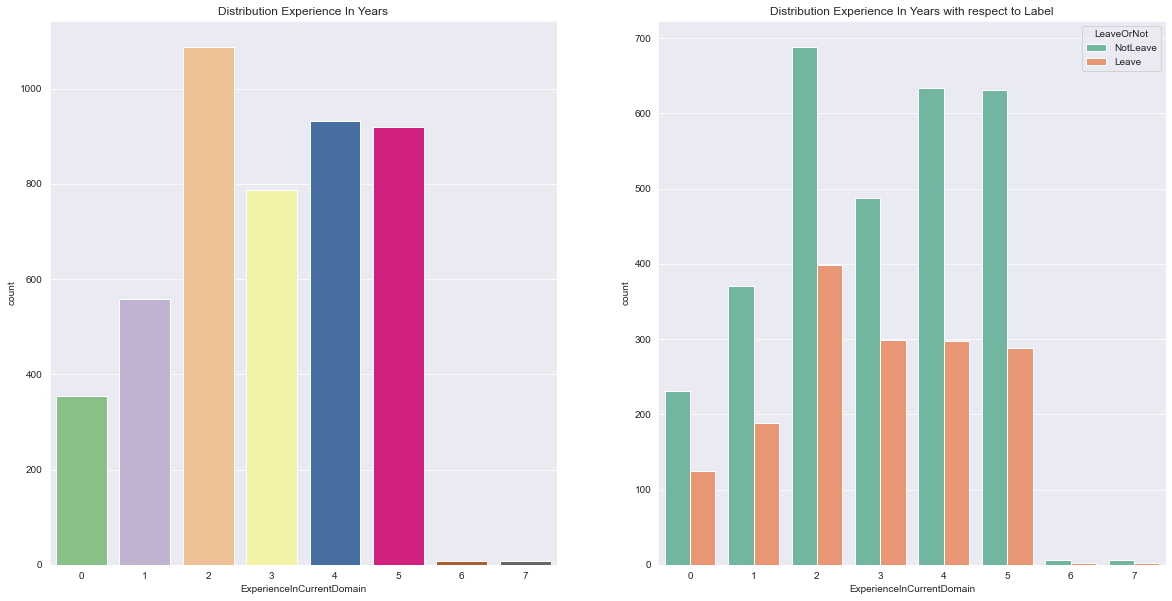

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(x = for_EDA['ExperienceInCurrentDomain'], palette='Accent', ax=ax[0])
ax[0].set_title('Distribution Experience In Years')

sns.countplot(x = for_EDA['ExperienceInCurrentDomain'], hue = for_EDA['LeaveOrNot'], palette='Set2', ax=ax[1])
ax[1].set_title('Distribution Experience In Years with respect to Label')

In [13]:
# 경력에 따른 직원 비율
print(f"경력에 따른 직원 비율 : {for_EDA['ExperienceInCurrentDomain'].value_counts(normalize=True)}")

# 경력에 따른 퇴사율
print(f"경력에 따른 퇴사율 : {for_EDA.groupby('ExperienceInCurrentDomain')['LeaveOrNot'].value_counts(normalize=True)}")

# 경력별 평균 나이
for_EDA_ecd_age = for_EDA.groupby("ExperienceInCurrentDomain")["Age"].mean()
print(f"경력별 평균 나이 : {for_EDA_ecd_age}")

경력에 따른 직원 비율 : 2    0.233613
4    0.200086
5    0.197507
3    0.168923
1    0.119923
0    0.076295
7    0.001934
6    0.001719
Name: ExperienceInCurrentDomain, dtype: float64
경력에 따른 퇴사율 : ExperienceInCurrentDomain  LeaveOrNot
0                          NotLeave      0.650704
                           Leave         0.349296
1                          NotLeave      0.663082
                           Leave         0.336918
2                          NotLeave      0.632935
                           Leave         0.367065
3                          NotLeave      0.619593
                           Leave         0.380407
4                          NotLeave      0.680988
                           Leave         0.319012
5                          NotLeave      0.686616
                           Leave         0.313384
6                          NotLeave      0.750000
                           Leave         0.250000
7                          NotLeave      0.666667
                        

## "Gender" Feature
Female, Male로 나뉘어져 있는 카테고리 Feature이다. 남자와 여자의 비율은 6:4 정도이다. 남성(25%)에 비해 여성(47%)의 퇴사율이 월등히 높다. 

특이점
- 여성이면서 pune 지역에 출근하는 여성들의 퇴사율은 82%로 여성의 퇴사율(47%)보다 높다. 
- 여성이면서 박사 학위를 가진 직원의 퇴사율은 26%로 여성의 퇴사율(47%)보다 낮다
- 남성이면서 석사 학위를 가진 직원의 퇴사율은 51%로 남성의 퇴사율(25%)보다 높다.
- 2015년에 입사한 여성 직원의 퇴사율은 60%로 다른 연도(30~40%)에 비해 높은 편이다(18년 제외)
- 여성이면서 2티어 pay를 받는 직원들의 퇴사율은 70%로 여성의 퇴사율(47%)보다 높다. 
- 남성이면서 1티어 pay를 받는 직원의 퇴사율(18%)은 1티어의 여성의 퇴사율(52%)보다 낮다.

In [14]:
for_EDA.groupby("Gender")["LeaveOrNot"].value_counts(normalize=True)

Gender  LeaveOrNot
Female  NotLeave      0.528533
        Leave         0.471467
Male    NotLeave      0.742261
        Leave         0.257739
Name: LeaveOrNot, dtype: float64

Text(0.5, 1.0, 'Distribution Gender with respect to Label')

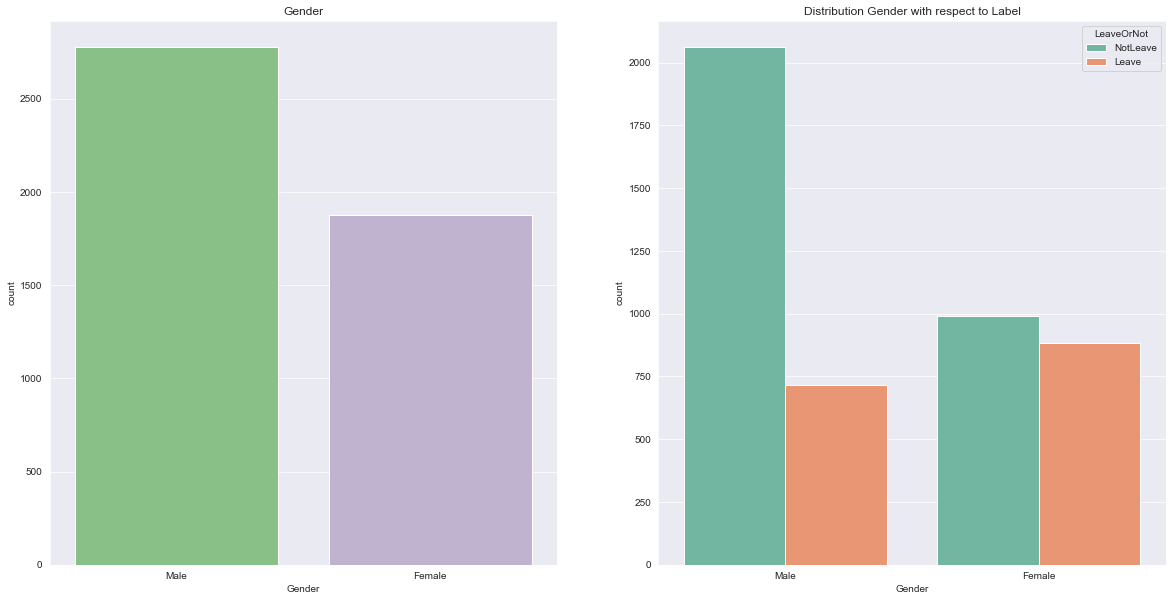

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.countplot(x = for_EDA['Gender'], palette='Accent', ax=ax[0])
ax[0].set_title('Gender')

sns.countplot(x = for_EDA['Gender'], hue = for_EDA['LeaveOrNot'], palette='Set2', ax=ax[1])
ax[1].set_title('Distribution Gender with respect to Label')

In [16]:
# 여성 & Pune 지역
for_EDA_female_p = for_EDA[(for_EDA.Gender == "Female") & (for_EDA.City == "Pune")]
print(f"여성 & Pune 지역 : {for_EDA_female_p['LeaveOrNot'].value_counts(normalize=True)}\n")

# 여성 & PHD 학위
for_EDA_female_phd = for_EDA[(for_EDA.Gender == "Female") & (for_EDA.Education == "PHD")]
print(f"여성 & PHD 학위 : {for_EDA_female_phd['LeaveOrNot'].value_counts(normalize=True)}\n")

# 남성 & Master 학위
for_EDA_male_mt = for_EDA[(for_EDA.Gender == "Male") & (for_EDA.Education == "Masters")]
print(f"남성 & Master 학위 : {for_EDA_male_mt['LeaveOrNot'].value_counts(normalize=True)}\n")

# 여성 & 15년 입사
for_EDA_female_j15 = for_EDA[(for_EDA.Gender == "Female") & (for_EDA.JoiningYear == 2015)]
print(f"여성 & 15년 입사 : {for_EDA_female_j15['LeaveOrNot'].value_counts(normalize=True)}\n")

# 여성 & PaymentTier 2
for_EDA_female_p2 = for_EDA[(for_EDA.Gender == "Female") & (for_EDA.PaymentTier == 2)]
print(f"여성 & PaymentTier 2 : {for_EDA_female_p2['LeaveOrNot'].value_counts(normalize=True)}\n")

# 남성 & PaymentTier 1
for_EDA_male_p1 = for_EDA[(for_EDA.Gender == "Male") & (for_EDA.PaymentTier == 1)]
print(f"남성 & PaymentTier 1 : {for_EDA_male_p1['LeaveOrNot'].value_counts(normalize=True)}\n")

여성 & Pune 지역 : Leave       0.823826
NotLeave    0.176174
Name: LeaveOrNot, dtype: float64

여성 & PHD 학위 : NotLeave    0.73913
Leave       0.26087
Name: LeaveOrNot, dtype: float64

남성 & Master 학위 : Leave       0.513944
NotLeave    0.486056
Name: LeaveOrNot, dtype: float64

여성 & 15년 입사 : Leave       0.595455
NotLeave    0.404545
Name: LeaveOrNot, dtype: float64

여성 & PaymentTier 2 : Leave       0.702479
NotLeave    0.297521
Name: LeaveOrNot, dtype: float64

남성 & PaymentTier 1 : NotLeave    0.821429
Leave       0.178571
Name: LeaveOrNot, dtype: float64



## "Education" Feature
직원들의 학력 상태를 나타내는 Feature이며, 총 3가지의 학력 상태가 나온다. Bachelors(학사), Masters(석사), PHD(박사)로 구성되어 있으며 각 비율은 77%, 19%, 4%로 이루어져 있다. 퇴사율은 31%, 48%, 25%씩이다.

특이점
- 박사 학력은 퇴사율이 낮은 편이지만 32 - 34세 나이대의 퇴사율은 71%로 가장 높은 반면 22-24세 나이대의 퇴사율은 0%이다.
- 석사 학력 중 22-24의 퇴사율은 77%로 석사 퇴사율(48%) 보다 높은 편이다.
- 학사 학력 중 Pune 지역에서 근무하는 직원의 퇴사율이 53%로 학사 퇴사율(31%)보다 높다. 
- 석사 학력 중 Bangalore 지역에 근무하는 직원의 퇴사율이 70%로 석사 퇴사율(48%)보다 높다.
- 박사 학력 중 Pune 지역에 근무하는 직원의 퇴사율은 17% 로 박사 퇴사율 (25%)보다 낮다.
- 석사 학력 중 장기 프로젝트에 참여하지 않은 직원의 퇴사율이 70%로 석사 퇴사율(48%)보다 높았다.
- 박사 학력 중 경력이 1인 직원의 퇴사율은 4%로 가장 낮았고, 3인 직원의 퇴사율은 42%로 가장 높았다. 
- 15년도에 입사한 직원 중 학사 학력을 가진 직원의 퇴사율은 35%로 다른 연도에 비해 가장 높았다(18년 제외)
- 13, 18년도에 퇴사한 박사 학력을 가진 직원의 퇴사율은 전체의 87%에 달하는 비중을 차지한다. 
- 학사 학력을 가진 직원 중 pay를 2티어로 받은 직원의 퇴사율은 72%로 학사 퇴사율(31%) 보다 높았다. 

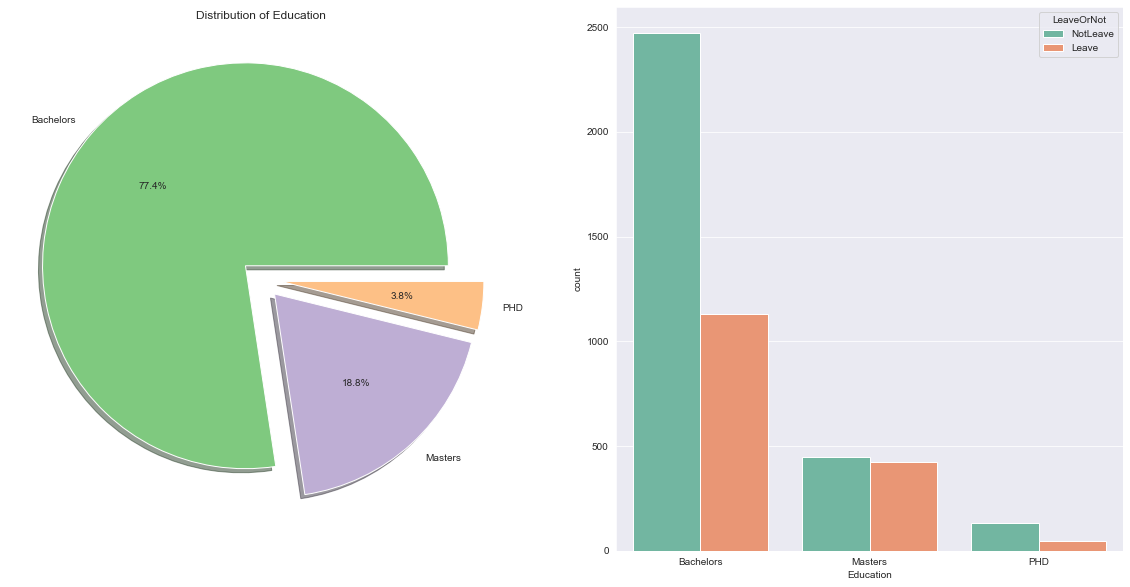

In [17]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
labels = for_EDA['Education'].value_counts().keys()
colors =cm.Accent(np.arange(7)/7)
plt.pie(x = for_EDA['Education'].value_counts(), 
       labels = labels,
       explode = (0.1,0.1,0.1),
       shadow = True, 
       colors = colors,
       autopct='%1.1f%%')
plt.title('Distribution of Education')

plt.subplot(1,2,2)
sns.countplot(x = for_EDA['Education'], hue = for_EDA['LeaveOrNot'] , palette='Set2')
plt.show()

In [18]:
# 학력별 퇴사 비율
for_EDA_ed = for_EDA.groupby("Education")
print(f"학력별 퇴사 비율 : {for_EDA_ed['LeaveOrNot'].value_counts(normalize=True)}\n")

# 박사 & 32-34
for_EDA_ph_age = for_EDA[(for_EDA.Education == "PHD") & ((for_EDA.Age >= 32) & (for_EDA.Age <34))]
print(f"박사 & 32-34 : {for_EDA_ph_age['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 석사 & 22-24
for_EDA_ms_age = for_EDA[(for_EDA.Education == "Masters") & ((for_EDA.Age >= 22) & (for_EDA.Age <24))]
print(f"석사 & 22-24 : {for_EDA_ms_age['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 학사 & Pune
for_EDA_bc_pn = for_EDA[(for_EDA.Education == "Bachelors") & (for_EDA.City == "Pune")]
print(f"학사 & Pune : {for_EDA_bc_pn['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 석사 & Bangalore
for_EDA_ms_ba = for_EDA[(for_EDA.Education == "Masters") & (for_EDA.City == "Bangalore")]
print(f"석사 & Bangalore : {for_EDA_ms_ba['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 박사 & Pune
for_EDA_ph_pn = for_EDA[(for_EDA.Education == "PHD") & (for_EDA.City == "Pune")]
print(f"박사 & Pune : {for_EDA_ph_pn['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 석사 & 1달이상 프로젝트에 참여 x
for_EDA_ms_eb = for_EDA[(for_EDA.Education == "Masters") & (for_EDA.EverBenched == "Yes")]
print(f"석사 & 1달이상 프로젝트에 참여 x : {for_EDA_ms_eb['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 박사 & ExperienceInCurrentDomain 1,3
for_EDA_ph_e1 = for_EDA[(for_EDA.Education == "PHD") & (for_EDA.ExperienceInCurrentDomain == 1)]
for_EDA_ph_e3 = for_EDA[(for_EDA.Education == "PHD") & (for_EDA.ExperienceInCurrentDomain == 3)]
print(f"박사 & ExperienceInCurrentDomain 1 : {for_EDA_ph_e1['LeaveOrNot'].value_counts(normalize=True)}\n" )
print(f"박사 & ExperienceInCurrentDomain 3 : {for_EDA_ph_e3['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 학사 & 15년 입사
for_EDA_ms_j15 = for_EDA[(for_EDA.Education == "Masters") & (for_EDA.JoiningYear == 2015)]
print(f"학사 & 15년 입사 : {for_EDA_ms_j15['LeaveOrNot'].value_counts(normalize=True)}\n" )

# 박사 & 13년, 18년 입사
for_EDA_ph = for_EDA[for_EDA.Education == "PHD"]
for_EDA_ph_j1318 = for_EDA[(for_EDA.Education == "PHD") & (for_EDA.JoiningYear.isin([2013, 2018]))]
print(f"박사 & 13년, 18년 입사 : {for_EDA_ph_j1318['LeaveOrNot'].value_counts() / for_EDA_ph['LeaveOrNot'].value_counts()}\n")


# 학사 & pay 2
for_EDA_ms_pay2 = for_EDA[(for_EDA.Education == "Bachelors") & (for_EDA.PaymentTier == 2)]
print(f"학사 & pay 2 : {for_EDA_ms_pay2['LeaveOrNot'].value_counts(normalize=True)}\n" )


학력별 퇴사 비율 : Education  LeaveOrNot
Bachelors  NotLeave      0.686476
           Leave         0.313524
Masters    NotLeave      0.512027
           Leave         0.487973
PHD        NotLeave      0.748603
           Leave         0.251397
Name: LeaveOrNot, dtype: float64

박사 & 32-34 : Leave       0.714286
NotLeave    0.285714
Name: LeaveOrNot, dtype: float64

석사 & 22-24 : Leave       0.769231
NotLeave    0.230769
Name: LeaveOrNot, dtype: float64

학사 & Pune : Leave       0.532609
NotLeave    0.467391
Name: LeaveOrNot, dtype: float64

석사 & Bangalore : Leave       0.701613
NotLeave    0.298387
Name: LeaveOrNot, dtype: float64

박사 & Pune : NotLeave    0.833333
Leave       0.166667
Name: LeaveOrNot, dtype: float64

석사 & 1달이상 프로젝트에 참여 x : Leave       0.707317
NotLeave    0.292683
Name: LeaveOrNot, dtype: float64

박사 & ExperienceInCurrentDomain 1 : NotLeave    0.961538
Leave       0.038462
Name: LeaveOrNot, dtype: float64

박사 & ExperienceInCurrentDomain 3 : NotLeave    0.580645
Leave       0.4

## "City" Feature
직원이 근무하고 있는 근무지를 나타내는 Feature로 인도의 3개 지역 Bangalore, New Delhi, Pune이 있다. 
각 지역의 비율은 48%, 25%, 27%씩이다. 퇴사율은 26%, 31%, 50%씩이다. 

특이점
- Bangalore 지역의 석사 학력의 직원의 퇴사율은 70%로 Bangalore 지역 퇴사율(26%)보다 높다.
- 박사 학력 중 Pune 지역에 근무하는 직원의 퇴사율은 17%로 Pune 지역 퇴사율(50%)보다 낮다.
- 여성 중 Pune 지역에 근무하는 직원의 퇴사율은 82%로 Pune 지역 퇴사율(50%)보다 높다.
- 남성 중 Pune 지역에 근무하는 직원의 퇴사율은 22%로 Pune 지역 퇴사율(50%)보다 낮다.
- Pune 지역 중 2015년에 입사한 직원의 퇴사율은 66%로 Pune 지역 퇴사율(50%)보다 높다.
- Bangalore 지역의 pay 1티어를 받는 직원의 퇴사율은 17%로 Bangalore 지역 퇴사율(26%)보다 낮다.
- Bangalore 지역의 pay 2티어를 받는 직원의 퇴사율은 70%로 Bangalore 지역 퇴사율(26%)보다 높다.
- Pune 지역의 pay 1, 2티어를 받는 직원의 퇴사율은 65%, 74%이고 3티어를 받는 직원의 퇴사율은 31%이다.

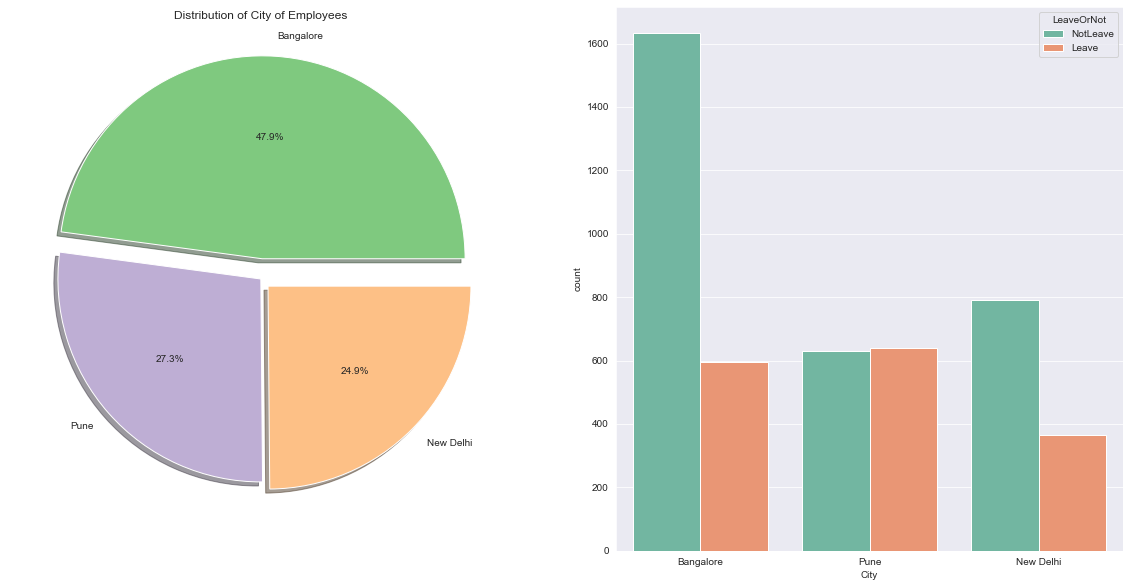

In [19]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
labels = for_EDA['City'].value_counts().keys()
colors =cm.Accent(np.arange(7)/7)
plt.pie(x = for_EDA['City'].value_counts(), 
       labels = labels,
       explode = (0.1,0,0.05),
       shadow = True, 
       colors = colors,
       autopct='%1.1f%%')
plt.title('Distribution of City of Employees')

plt.subplot(1,2,2)
sns.countplot(x = for_EDA['City'], hue = for_EDA['LeaveOrNot'], palette='Set2')
plt.show()

In [20]:
# 도시별 퇴사 비율
for_EDA_ct = for_EDA.groupby("City")
print(f"도시별 퇴사 비율 : {for_EDA_ct['LeaveOrNot'].value_counts(normalize=True)}\n")

# Pune & 남성
for_EDA_pu_male = for_EDA[(for_EDA.City == "Pune") & (for_EDA.Gender == "Male")]
print(f"Pune & 남성 : {for_EDA_pu_male['LeaveOrNot'].value_counts(normalize=True)}\n" )

# Pune & 2015년 입사
for_EDA_pu_j15 = for_EDA[(for_EDA.City == "Pune") & (for_EDA.JoiningYear == 2015)]
print(f"Pune & 2015년 입사 : {for_EDA_pu_j15['LeaveOrNot'].value_counts(normalize=True)}\n" )

# Bangalore & Pay 1, 2
for_EDA_ba_pay1 = for_EDA[(for_EDA.City == "Bangalore") & (for_EDA.PaymentTier == 1)]
for_EDA_ba_pay2 = for_EDA[(for_EDA.City == "Bangalore") & (for_EDA.PaymentTier == 2)]
print(f"Bangalore & Pay 1 : {for_EDA_ba_pay1['LeaveOrNot'].value_counts(normalize=True)}\n" )
print(f"Bangalore & Pay 2 : {for_EDA_ba_pay2['LeaveOrNot'].value_counts(normalize=True)}\n" )

# Pune & Pay 1, 2, 3
for_EDA_pu_pay1 = for_EDA[(for_EDA.City == "Pune") & (for_EDA.PaymentTier == 1)]
for_EDA_pu_pay2 = for_EDA[(for_EDA.City == "Pune") & (for_EDA.PaymentTier == 2)]
for_EDA_pu_pay3 = for_EDA[(for_EDA.City == "Pune") & (for_EDA.PaymentTier == 3)]
print(f"Pune & Pay 1 : {for_EDA_pu_pay1['LeaveOrNot'].value_counts(normalize=True)}\n" )
print(f"Pune & Pay 2 : {for_EDA_pu_pay2['LeaveOrNot'].value_counts(normalize=True)}\n" )
print(f"Pune & Pay 3 : {for_EDA_pu_pay3['LeaveOrNot'].value_counts(normalize=True)}\n" )


도시별 퇴사 비율 : City       LeaveOrNot
Bangalore  NotLeave      0.732944
           Leave         0.267056
New Delhi  NotLeave      0.683665
           Leave         0.316335
Pune       Leave         0.503943
           NotLeave      0.496057
Name: LeaveOrNot, dtype: float64

Pune & 남성 : NotLeave    0.779762
Leave       0.220238
Name: LeaveOrNot, dtype: float64

Pune & 2015년 입사 : Leave       0.663664
NotLeave    0.336336
Name: LeaveOrNot, dtype: float64

Bangalore & Pay 1 : NotLeave    0.821429
Leave       0.178571
Name: LeaveOrNot, dtype: float64

Bangalore & Pay 2 : Leave       0.707692
NotLeave    0.292308
Name: LeaveOrNot, dtype: float64

Pune & Pay 1 : Leave       0.653333
NotLeave    0.346667
Name: LeaveOrNot, dtype: float64

Pune & Pay 2 : Leave       0.742
NotLeave    0.258
Name: LeaveOrNot, dtype: float64

Pune & Pay 3 : NotLeave    0.683983
Leave       0.316017
Name: LeaveOrNot, dtype: float64



## "EverBenched" Feature
장기 프로젝트(1달 이상)에 참여를 하지 않는지를 나타내는 Feature이다. 장기 프로젝트에 참여 여부에 따라 No(참여함), Yes(참여 안 함) 두 가지 값을 갖는다. 각각의 비율은 90%, 10%이고 퇴사율은 각각 33%, 45%이다. 

특이점
- Pune 지역에 근무하는 직원의 퇴사율은 장기 프로젝트의 참여여부에 따라 각각 48%, 65%으로 장기 프로젝트 참여 여부에 따른 퇴사율(33%, 45%)보다 높다.
- 장기 프로젝트에 참여하지 않은 직원 중 석사 학력을 가지고 있는 직원의 퇴사율은 70%로 장기 프로젝트에 참여하지 않은 직원의 퇴사율(45%)보다 높다.
- 장기 프로젝트에 참여한 직원 중 여성 직원의 퇴사율은 60%로 장기 프로젝트에 참여한 직원의 퇴사율(33%)보다 높다.
- 장기 프로젝트에 참여하지 않은 직원 중 12, 14, 16년도 입사자는 전체 퇴사율의 6%로 장기 프로젝트에 참여하지 않은 직원의 퇴사율(45%)보다 낮다. 
- 장기 프로젝트에 참여하지 않은 직원 중 pay 2티어를 받는 직원의 퇴사율은 80%로 장기 프로젝트에 참여하지 않은 직원의 퇴사율(45%)보다 높다. 

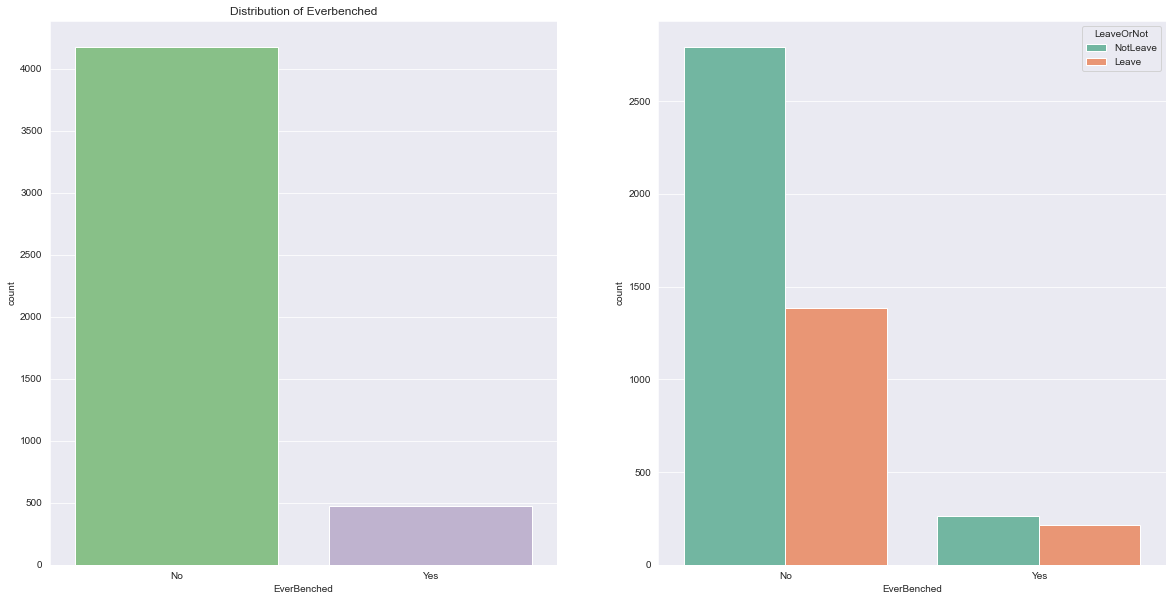

In [21]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
sns.countplot(x = for_EDA['EverBenched'] , palette='Accent')
plt.title('Distribution of Everbenched')
plt.subplot(1,2,2)
sns.countplot(x = for_EDA['EverBenched'] ,hue = for_EDA['LeaveOrNot'], palette='Set2')
plt.show()

In [22]:
# 프로젝트 참여 여부에 따른 퇴사율
for_EDA_eb = for_EDA.groupby("EverBenched")
print(f"프로젝트 참여 여부에 따른 퇴사율 : {for_EDA_eb['LeaveOrNot'].value_counts(normalize=True)}\n")


# Pune 지역에서 근무하며 프로젝트 참여 여부에 따른 퇴사율
for_EDA_pu_eb = for_EDA[for_EDA.City == "Pune"].groupby("EverBenched")
print(f"Pune 지역에서 근무하며 프로젝트 참여 여부에 따른 퇴사율 : {for_EDA_pu_eb['LeaveOrNot'].value_counts(normalize=True)}\n")

# 프로젝트 참여 하지 않음 & 석사 학력
for_EDA_ms_ebx = for_EDA[(for_EDA.EverBenched == "Yes") & (for_EDA.Education == "Masters")]
print(f"프로젝트 참여 하지 않음 & 석사 학력 : {for_EDA_ms_ebx['LeaveOrNot'].value_counts(normalize=True)}\n")

# 프로젝트 참여 하지 않음 & 여성
for_EDA_female_ebx = for_EDA[(for_EDA.EverBenched == "Yes") & (for_EDA.Gender == "Female")]
print(f"프로젝트 참여 하지 않음 & 여성 : {for_EDA_female_ebx['LeaveOrNot'].value_counts(normalize=True)}\n")

# 프로젝트 참여 하지 않음 & pay 2
for_EDA_pay2_ebx = for_EDA[(for_EDA.EverBenched == "Yes") & (for_EDA.PaymentTier == 2)]
print(f"프로젝트 참여 하지 않음 & pay 2 : {for_EDA_pay2_ebx['LeaveOrNot'].value_counts(normalize=True)}\n")

# 프로젝트 참여 하지 않음 & 12, 14, 16년도 입사자
for_EDA_j121416_ebx = for_EDA[(for_EDA.EverBenched == "Yes") & (for_EDA.JoiningYear.isin([2012, 2014, 2016]))]
for_EDA_ebx = for_EDA[for_EDA.EverBenched == "Yes"]
print(f"프로젝트 참여 하지 않음 & 12, 14, 16년도 입사자 : {for_EDA_j121416_ebx['LeaveOrNot'].value_counts() / for_EDA_ebx['LeaveOrNot'].value_counts()}\n")



프로젝트 참여 여부에 따른 퇴사율 : EverBenched  LeaveOrNot
No           NotLeave      0.668743
             Leave         0.331257
Yes          NotLeave      0.546025
             Leave         0.453975
Name: LeaveOrNot, dtype: float64

Pune 지역에서 근무하며 프로젝트 참여 여부에 따른 퇴사율 : EverBenched  LeaveOrNot
No           NotLeave      0.514563
             Leave         0.485437
Yes          Leave         0.659259
             NotLeave      0.340741
Name: LeaveOrNot, dtype: float64

프로젝트 참여 하지 않음 & 석사 학력 : Leave       0.707317
NotLeave    0.292683
Name: LeaveOrNot, dtype: float64

프로젝트 참여 하지 않음 & 여성 : Leave       0.603352
NotLeave    0.396648
Name: LeaveOrNot, dtype: float64

프로젝트 참여 하지 않음 & pay 2 : Leave       0.806452
NotLeave    0.193548
Name: LeaveOrNot, dtype: float64

프로젝트 참여 하지 않음 & 12, 14, 16년도 입사자 : NotLeave    0.467433
Leave       0.064516
Name: LeaveOrNot, dtype: float64



## 2. 데이터 분석(EDA) - EDA 결과 정리
데이터를 분석해 본 결과 다음과 같은 유의미한 정보를 얻게 되었다. 

### 데이터 인사이트 관점
1. 2018년에 입사한 직원의 98%는 퇴사했다. 남은 2%의 인원 5명을 분석해 보면 모두 고수준(1티어)의 연봉을 받고 있었으며 여성 1, 남성 4 이었다. 다른 요인에도 불구하고 98%가 퇴사를 했다는 의미는 자발적인 퇴사보다는 회사 내 특별한 사정으로 인해 퇴사했을 가능성이 있다. 예를 들어 18년에 입사자가 들어가는 자회사 또는 공장이 문을 닫으면서 대량 해고가 되었을 수도 있다. 회사는 대량 해고 와중에 고수준의 연봉의 인재 일부는 남겨두는 전략을 취했을 수도 있다.

2. 남성(25%)보다 여성(47%)의 퇴사율이 2배가량 높다. 인도는 가부장적인 문화가 널리 퍼져있는 국가이므로 문화적인 요인으로 남녀 퇴사율의 차이가 있을 가능성이 있다. 

3. Pune 지역의 퇴사율이 50%로 다른 지역에 2배 가량 된다. 3개의 지역 중 특정 지역의 퇴사율이 높다는 것은 해당 지역의 근무여건이 열악하거나, 사업체의 수익이 좋지 않아 정리해고가 많은 경우일 수도 있다.

4. pay가 중간 수준(2티어)인 직원의 퇴사율은 60%로 높다. 또 중간 수준의 연봉을 받으며 장기 프로젝트(1개월 이상 프로젝트)를 하지 않는 직원의 퇴사율은 80%에 달한다. 이것으로 보아 어느 정도 실력이 있는 인재들에게 단기 프로젝트의 업무가 주어진다면 불만이 생길 수 있다는 것을 유추할 수 있다.

5. 경력 5의 비율(20%)에 비해 경력 6 이상의 비율은 2%대로 급격하게 줄었다. 경력 6, 7의 직원 75% 이상이 낮은 연봉을 받고, 최소 연령이 38살인 것으로 보아 일반적인 직원과 다른 업무를 하고 있을 가능성이 있다. 근로시간이 다른 partime 일 가능성도 있다.

6. 박사 학력을 가진 직원의 퇴사율은 25%이지만, 13, 18년도에 퇴사한 박사 학력을 가진 직원의 퇴사율은 무려 전체의 87%에 달한다. 13, 18년에 R&D 관련 예산을 대폭 줄였을 가능성이 있다. 

7. 장기 프로젝트를 참여한 직원들의 퇴사율(33%)이 그렇지 않은 직원들의 퇴사율(45%)보다 높다. 일반적으로는 프로젝트를 진행하는 중간에 퇴사하는 일은 적으므로 직원들을 장기프로젝트에 독려하는 것은 퇴사율을 줄이는 한 방법이 될 수 있을 것이다. 


### 데이터 전처리 관점
1. Age의 값이 20개 정도 되어 학습을 위해 나이를 2살씩 묶어서 Feature를 구성할 것이다. 

2. JoiningYear의 값이 int인데 다른 Feature보다 값이 크다(4자리). 적은 수로 매핑해서 처리할 것이다.

3. 경력 6,7의 데이터는 수도 매우 적을뿐더러 해당 데이터를 자세히 살펴본 결과 일반적인 직원과 다른 형태의 데이터이므로 outlier로 판단하여 제거할 것이다.

4. outlier 데이터가 많지 않고, 수치형이라도 대부분 카테고리에 가까워서 추가적인 Scale 작업은 하지 않을 예정이다. 일반적인 경우 sklearn 라이브러리에서 Scaler 작업을 하거나 IQR 방식의 outlier 제거를 하기도 한다.

##  3. 데이터 전처리 - 모델에 들어갈 데이터 셋 만들기

- 기본적인 전처리 작업을 한 후 데이터 셋을 tf.Dataset형태로 바꾸어 넣을 것이다. tf.Dataset 형태의 데이터 셋은 Tensorflow 딥러닝에 한해 대용량 데이터에 대해 빠르게 학습을 시킬 수 있다는 장점이 있다. 

In [23]:
# JoiningYear 
raw_dataset["JoiningYear"] = raw_dataset["JoiningYear"].map({year:num for num, year in enumerate(range(2012, 2019))})

# outlier 제거
raw_dataset = raw_dataset[raw_dataset.ExperienceInCurrentDomain.isin(list(range(6)))]


In [24]:
# data 분리하기 train : val : test = 6 : 2 : 2
train_dataset, val_dataset, test_dataset = np.split(
    raw_dataset, [int(len(raw_dataset)*0.6), int(len(raw_dataset)*0.8)])

# tf.Dataset 만들기 
def make_dataset(df, shuffle=True, batch_size=32):
    dataframe = df.copy()
    features, labels = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]
    
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features))
    ds = ds.batch(batch_size)
    return ds

In [25]:
# train, val, test 데이터 셋 만들기
BATCH_SIZE = 32
train_ds = make_dataset(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_ds = make_dataset(val_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_ds = make_dataset(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

## 4. 모델 만들기

이번 데이터 셋에 사용하게 될 모델은 Wide and Deep 딥러닝 모델이다. Wide and Deep는 구글이 2016년 발표한 "Wide & Deep Learning for Recommender Systems" 논문에서 나온 알고리즘으로 검색, 추천 시스템, 랭킹 모델에서 전체 트래픽은 많지만 매칭된 데이터는 드문 경우 활용될 수 있다고 한다. 모델이 너무 구체화되거나 너무 일반화되는 것을 적절히 안배하기 위해 고안되었다고 한다. 

Wide and Deep 모델은 (와이드 모델 + 딥 모델)을 합친 것으로 이해하면 된다. 와이드 모델은 Memorization에 특화된 Linear wide 모델이고, 카테고리 분류와 같은 비연속성을 가지는 데이터(특히 cross-product 컬럼이 유용)가 학습 Feature로 적합하다. 딥 모델은 Generalization에 특화된 non-linear deep 모델이고, 연속성을 가지거나 임베딩을 해야 하는 데이터가 학습 Feature로 적절하다.

In [26]:
NUMERIC_FEATURES = ["JoiningYear", "PaymentTier", "Age", "ExperienceInCurrentDomain"]
CATEGORY_FEATURES = ["Gender", "Education", "City", "EverBenched"]
LABELS = ["LeaveOrNot"]

# inputs
inputs_nu = {colname : Input(name=colname, shape=(), dtype=tf.int64) for colname in NUMERIC_FEATURES}
inputs_ca = {colname : Input(name=colname, shape=(), dtype=tf.string) for colname in CATEGORY_FEATURES}
inputs = {**inputs_nu, **inputs_ca}

# category feature columns
gender = feature_column.categorical_column_with_vocabulary_list(
        "Gender", raw_dataset["Gender"].unique())
education = feature_column.categorical_column_with_vocabulary_list(
        "Education", raw_dataset["Education"].unique())
city = feature_column.categorical_column_with_vocabulary_list(
        "City", raw_dataset["City"].unique())
everbenched = feature_column.categorical_column_with_vocabulary_list(
        "EverBenched", raw_dataset["EverBenched"].unique())
    
# numerical feature columns
age = feature_column.numeric_column("Age")
joiningyear = feature_column.numeric_column("JoiningYear")
paymenttier = feature_column.numeric_column("PaymentTier")
experienceincurrentdomain = feature_column.numeric_column("ExperienceInCurrentDomain")

# Age bucket
age_buckets = feature_column.bucketized_column(
    age, boundaries=[24, 26, 28, 30, 32, 34, 36, 38, 40])

# crossed_columns
crossed_feature = tf.feature_column.crossed_column(
        [age_buckets, everbenched], hash_bucket_size=1000)

crossed_feature2 = tf.feature_column.crossed_column(
        [gender, education], hash_bucket_size=1000)




In [27]:
# wide columns
wide_columns = [
    # category column
    feature_column.indicator_column(gender), 
    feature_column.indicator_column(education), 
    feature_column.indicator_column(city), 
    feature_column.indicator_column(everbenched), 
    
    # crossed_columns
    feature_column.indicator_column(crossed_feature), 
    feature_column.indicator_column(crossed_feature2),
    
    # bucket화된 컬럼
    age_buckets
]

# deep columns
deep_columns = [
    # embedding column - City
    tf.feature_column.embedding_column(city, dimension=4),
    
    # numeric column 추가
    age,
    joiningyear,
    paymenttier,
    experienceincurrentdomain
]



In [28]:
def build_model(inputs):

    # wide 모델 만들기 - linear
    wide = DenseFeatures(wide_columns, name="wide_inputs")(inputs)
    
    # deep 모델 만들기 - non linear(복잡)
    deep = DenseFeatures(deep_columns, name="deep_inputs")(inputs)
    deep = Dense(128, activation="tanh")(deep)
    deep = Dropout(0.2)(deep)
    deep = Dense(64, activation="relu")(deep)
    deep = Dropout(0.2)(deep)
    deep = Dense(8, activation="relu")(deep)
    deep = Dropout(0.2)(deep)
    deep = Dense(4, activation="relu")(deep)
    deep = Dropout(0.2)(deep)
    
    
    # wide 모델과 deep 모델을 조합
    combined = concatenate(inputs=[deep, wide], name='combined')
    
    outputs = Dense(1, activation="sigmoid",name="prediction")(combined)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model



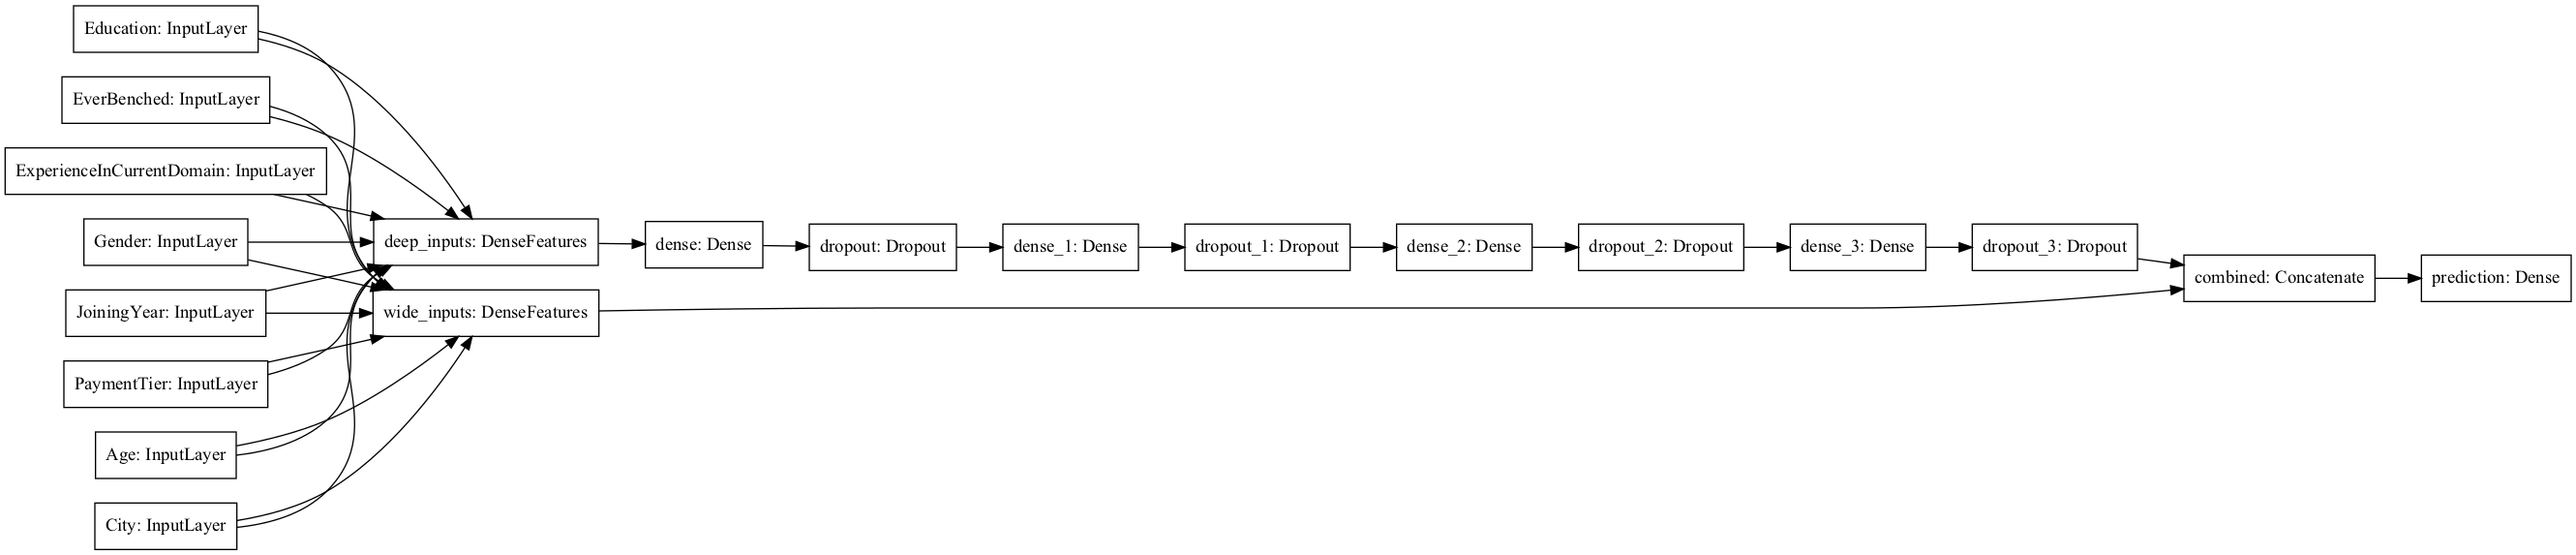

In [29]:
model = build_model(inputs)
keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

In [34]:
EPOCHS = 100
OUTDIR_ck = "./ck/"
OUTDIR_tb = "./efp_train/"

ck = ModelCheckpoint(filepath=OUTDIR_ck,
                     mode="min", monitor="val_loss",
                     verbose=1, save_best_only=True)

es = EarlyStopping(monitor="val_loss",
                  min_delta=0.0001,
                  patience=10,
                  verbose=1,
                  mode="min",
                  restore_best_weights=True)

tb = TensorBoard(log_dir=OUTDIR_tb, histogram_freq=1)
shutil.rmtree(path=OUTDIR_ck, ignore_errors=True)
shutil.rmtree(path=OUTDIR_tb, ignore_errors=True)

history = model.fit(x=train_ds, 
                    epochs=EPOCHS,
                   verbose=1,
                   validation_data=val_ds,
                   callbacks=[tb, ck, es])

Epoch 1/100
87/87 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.7832 - val_loss: 0.5556 - val_accuracy: 0.7551

Epoch 00001: val_loss improved from inf to 0.55555, saving model to ./ck/


INFO:tensorflow:Assets written to: ./ck/assets


INFO:tensorflow:Assets written to: ./ck/assets


Epoch 2/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5103 - accuracy: 0.7835 - val_loss: 0.5798 - val_accuracy: 0.7389

Epoch 00002: val_loss did not improve from 0.55555
Epoch 3/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5046 - accuracy: 0.7878 - val_loss: 0.5641 - val_accuracy: 0.7400

Epoch 00003: val_loss did not improve from 0.55555
Epoch 4/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5086 - accuracy: 0.7846 - val_loss: 0.5846 - val_accuracy: 0.7184

Epoch 00004: val_loss did not improve from 0.55555
Epoch 5/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5051 - accuracy: 0.7860 - val_loss: 0.5740 - val_accuracy: 0.7260

Epoch 00005: val_loss did not improve from 0.55555
Epoch 6/100
87/87 [==============================] - 0s 2ms/step - loss: 0.5005 - accuracy: 0.7900 - val_loss: 0.5781 - val_accuracy: 0.7228

Epoch 00006: val_loss did not improve from 0.55555
Epoch 7/100
87/87 [================

In [35]:
# Ipython에 tensorboard를 띄우기 위해
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
%tensorboard --logdir efp_train/

Reusing TensorBoard on port 6006 (pid 83494), started 0:01:38 ago. (Use '!kill 83494' to kill it.)

![tensorboard](./image/tensorboard.png)

## 5. 모델 성능 평가하기
tensorboard의 학습형태를 보면 우하향곡선을 그리는 것으로 보아 학습이 괜찮게 되었다는 것을 알 수 있다. 

모델의 성능을 평가하는 여러 가지 방법이 있는데 가장 손쉬운 방법은 model.evaluate(dataset)을 활용하는 것이다. 이번 모델의 경우 이진 분류이므로 sklearn의 confusion_matrix를 활용하면 좀더 정확한 성능을 측정할 수 있다.

Accuracy :  0.6056034482758621
Recall :  0.1912751677852349
Precision :  0.3131868131868132
f1_score :  0.2375


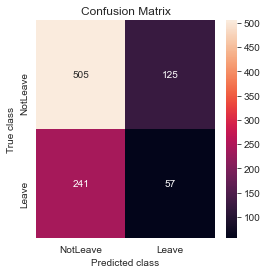

In [37]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, auc, roc_curve

pred = model.predict(test_ds)

conf_matrix = confusion_matrix(test_dataset["LeaveOrNot"], np.around(pred))

LABELS=["NotLeave", "Leave"]

plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")

print("Accuracy : ", accuracy_score(test_dataset["LeaveOrNot"], np.around(pred)))
print("Recall : ", recall_score(test_dataset["LeaveOrNot"], np.around(pred)))
print("Precision : ", precision_score(test_dataset["LeaveOrNot"], np.around(pred)))
print("f1_score : ", f1_score(test_dataset["LeaveOrNot"], np.around(pred)))

## 6. 결론 및 보완점
해당 모델은 정확도 0.63에 f1_score의 값이 0.22로 나왔다. 학습이 원활히 되었음에도 성능이 저조하게 나온 이유를 분석하면 다음과 같다. 

1. 데이터 이슈) 해당 데이터 셋이 실제 데이터 셋이 공식적인 기관에서 배포한 데이터 셋이 아니라 개인이 Kaggle에 올린 데이터 셋이므로 신뢰도가 떨어진다.
2. 모델 이슈) wide and deep 모델은 많은 데이터와 많은 feature에서 좀 더 나은 성능을 보인다고 알려져 있다. 이번 데이터 셋의 규모가 작아서 모델이 비효율적으로 학습되었을 수도 있다. 


### 보완점 
1. 많은 Feature에 강점을 발휘하는 wide and deep 모델이므로 cross-product 컬럼을 더 늘려보는 것도 좋은 방법일 것이다. 
2. loss 함수, optimizer 등을 변경함으로써 성능을 개선할 수 있을 것이다. 실제 논문에서는 optimizer로 Follow-the-regularized-leader(FTRL) 알고리즘를 사용했다고 나와있는데 이 부분을 추가로 검토하여 적용해 보는 것도 성능 개선에 도움이 될 수 있을 것이다.
3. 각 레이어 및 함수에 하이퍼 파라미터를 조정한다면 성능 개선에 도움이 될 수 있을 것이다. 
4. 딥러닝 말고 Randomforest, SVD 등 다양한 머신러닝 알고리즘을 적용해 보는 것도 성능 개선에 도움이 될 수 있을 것이다. 
